In [1]:
#imports
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import HSS

In [2]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
font = {#'family' : 'Helvetica',
        'size'   : 12}
mpl.rc('font', **font)

In [3]:
path_plot = '/users/caganze/research/stellarstreams/figures/streamssims/'

In [4]:
import astropy.coordinates as coord
_ = coord.galactocentric_frame_defaults.set('v4.0')

In [5]:
#use NFW POTENTIAL BECAUSE THE HALO? 
pot = gp.NFWPotential.from_circular_velocity(v_c=220*u.km/u.s, r_s=15*u.kpc, units=galactic)
#CONSTRUCT A HAMILTONIAN
H = gp.Hamiltonian(pot)

In [6]:
def detect_gaps(density, x, y, z, npeaks=5, threshold=0.0, verbose=False):
    peak_idxs=[]
    peaks,  _ = find_peaks(density, threshold=0.)
    for n in np.arange(npeaks):
        peak_idx= peaks[n]
        if verbose:
            print ('{} th peak at  xyz position {}'.format(n+1, (x[peak_idx], y[peak_idx], z[peak_idx])))
        peak_idxs.append(peak_idx)
    return peak_idxs

In [7]:
def generate_stream(mass, prog_w0, dt=8 * u.Myr, nsteps=1000):
    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun
    gen = ms.MockStreamGenerator(df, H)
    stream, prog = gen.run(prog_w0, prog_mass ,dt=dt, n_steps=nsteps)
    return stream, prog
    
    

In [8]:
def rotate(vs, c, ang):
    """
    rotation of a 2d-vector 
    input: vs: 2d-vector
    c: center of rotation
    ang: angle in radian
    
    """
    r=[[np.cos(ang), -np.sin(ang)],
         [np.sin(ang), np.cos(ang)]]

    i=np.identity(2)

    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
            [r[1][0], r[1][1], np.dot(i-r, c)[1]],
            [0., 0., 1.]])

    xs=vs[:, 0]
    ys=vs[:, 1]

    zs=np.array([1. for x in xs])

    rotated=np.array(np.dot(mat, np.array([xs, ys, zs])))
    
    
    return  np.array([rotated[0], rotated[1]])

In [9]:
def add_fake_gap(stream, cent, radius):
    """
    Create a fake circular grap in a stellar stream
    
    
    Input: center, 3d-radius all in kpc
    
    returns a mask array
    """
    x, y, z=stream.cartesian.x.to(u.kpc).value, stream.cartesian.y.to(u.kpc).value,\
    stream.cartesian.z.to(u.kpc).value
    #compute absolute distance 
    r= (x-cent[0])**2+(y-cent[1])**2+(z-cent[-1])**2
    return  r> radius

In [10]:
def generate_random_lb(center, n):
    #spatial l and b
    lg= np.random.uniform(0, 1, int(n))
    bg=np.random.uniform(0, 1,  int(n))
    x=2*np.pi*lg*u.radian
    y=(np.arccos(2*bg-1)-np.pi/2)*u.radian
    
    return (x-center[0], y-center[-1])

In [198]:
def create_3d_circular_mask(x, y, z, center=None, radius=None):
    dist_from_center = np.sqrt((x - center[0])**2 + (y-center[1])**2 + (z-center[-1])**2)
    mask = dist_from_center <= radius
    return mask

def create_2d_circular_mask(x, y, center=None, radius=None):
    dist_from_center = np.sqrt((x - center[0])**2 + (y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

In [301]:
def make_fake_stream_plus_gap(mass, steps, age_step, pos, vel, HSS_args, gap_size=0.5,\
                              rotation_angle=np.pi/4, nbackground=1e4, filename='fake_stream', 
                             circular_radius=0.5, back_ground_radius=15, add_backg=False, plot_hss=True):
    """
    Creates a stream and and input a fake gap 
    
    Returns the stream object and mask array and rotated stream plus backgroudn
    """
    #pick a phase space position
    prog_w0 = gd.PhaseSpacePosition(pos=pos ,
                                    vel=vel)
    #generate stream
    stream, pr= generate_stream(mass, prog_w0, dt=age_step, nsteps=steps )
    
    x_totl = stream.cartesian.x.to(u.kpc).value
    y_totl = stream.cartesian.y.to(u.kpc).value
    z_totl= stream.cartesian.z.to(u.kpc).value
    
    #
    
    stream_tot=SkyCoord(x=x_totl*u.kpc, y=y_totl*u.kpc, z=z_totl*u.kpc, frame='galactocentric')
    
    #set up the rotation
    total_dist=  np.sqrt(np.nansum([stream_tot.cartesian.x.value**2,\
                             stream_tot.cartesian.y.value**2,\
                             stream_tot.cartesian.z.value**2], axis=0))
    
    vals=np.vstack([ stream_tot.cartesian.x.value/total_dist, stream_tot.cartesian.y.value/total_dist])
                         

    
    rotated=rotate(vals.T, np.nanmedian(vals, axis=1), rotation_angle)
    #add gap
    center=(np.nanmean(rotated[0]),np.nanmean(rotated[-1]))
                         
    #if add background
    if  add_backg:
        #
        abs_x=np.nanmax(np.abs(rotated[0]))
        abs_y=np.nanmax(np.abs(rotated[-1]))
        rdx= np.random.uniform(-abs_x*back_ground_radius, \
                               abs_x*back_ground_radius, int(nbackground)) 
        rdy= np.random.uniform(-abs_y*back_ground_radius, \
                               abs_y*back_ground_radius, int(nbackground))
        rotated= [np.concatenate([rotated[0], rdx]), np.concatenate([rotated[-1], rdy])]
        
    #pick the gap position as the center of the stream
    circular_mask= create_2d_circular_mask(rotated[0], rotated[-1],\
                                  center=center, \
                                     radius= circular_radius)
    
    
    mask=create_2d_circular_mask(rotated[0], rotated[-1],\
                                  center=center, \
                                     radius=gap_size)
    
    mask_tot=np.logical_and(circular_mask, ~mask)

    rotated= [rotated[0][mask_tot],  rotated[-1][mask_tot]]
    
    #HSS stuff 
    if  plot_hss:
        HSS_args['pos']=rotated[0], rotated[-1]  #in deg here, can also be unitless
        HSS_args['kpc_conversion'] = np.pi * HSS_args['d_galaxy'] / 180.


        HSS.RT_plot(HSS_args['pos'], HSS_args['unit'], HSS_args['kpc_conversion'],\
                    HSS_args['delta_t'], HSS_args['drho'],  HSS_args['outlier'],\
                    HSS_args['pointsize'], HSS_args['mask'], filename,
                path_plot, HSS_args['verbose'], HSS_args['rho_edge'])
    
    return stream,  stream_tot, rotated, center

In [471]:
HSS_args={'unit':"unitless",
          'd_galaxy': 1 , #this probably doesn't apply                     
          'delta_t': 1.,     
          'drho' : 0.02,     
          'outlier': . , 
          'pointsize': 1,
          'mask': False,
          'verbose': True,
          'rho_edge': False}

In [472]:
poss=[([8.3, 5., 1000.])*u.kpc, ([10, 15., 0.])*u.kpc, ([0., 5., 0.])*u.kpc]
vels=[([-10, 0, 0.])*u.kpc/u.Gyr, ([-10, 3, 1.])*u.kpc/u.Gyr, ([-10, 3, 19.])*u.kpc/u.Gyr]
angles=[np.pi/3, 0.75*np.pi, np.pi/4]
masses=[1e4, 5e4, 1e5]
drhos=[1.0, 2., 5.]

In [457]:
import itertools

In [483]:
s,_, rot, c =make_fake_stream_plus_gap(5e5, 1000, 6.*u.Myr,  poss[0], vels[0], HSS_args, \
                            gap_size=0.007,\
                            rotation_angle=angles[0], nbackground=1e5, filename='fake_stream', 
                            circular_radius=0.5, back_ground_radius=10., add_backg=True, plot_hss=False)

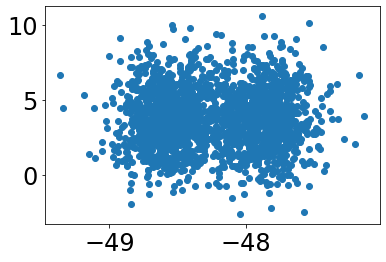

In [484]:
fig, ax=plt.subplots()
plt.scatter(s.cartesian.x, s.cartesian.y)

In [ ]:
if False:
    for perm in list(itertools.product(*[poss, vels, angles, masses,drhos ])):

        try:
            pos, vel, ang, mass, drho=perm

            r_pos=np.round(np.nansum(pos.value**2)**0.5)
            r_vel=np.round(np.nansum(vel.value**2)**0.5)

            filename='stream_pos{}_vel{}_mass{}_ang{}_drho{}_'.format(r_pos, r_vel, mass,  ang, drho)
            HSS_args['drho']=drho
            stream, mask, stream_plus_backg, gap_pos, circular_mask=make_fake_stream_plus_gap(mass, 1000, 9*u.Myr, pos, vel, HSS_args, \
                                                                                          gap_size=0.5,\
                                      rotation_angle=ang, nbackground=1e5, filename=filename, 
                                     circular_radius=5., back_ground_radius=300)
        except ValueError:
            pass

In [ ]:
#
# 1) save the stream in a file after it's made 
# 2) generate a circular background pos 
# 3) srore 
# 4) approx stream 

In [ ]:
#30 kpc
#200 km/s
#milky ay 
#-70 and 70 kpc
#mass = 1e4, 5Gyr
#mass =1e6, Gyr
#put these in andromeda
#rotate it so it's tilted 
#drop the gaps for a minute
#figure out to rotate things 
#Helmer's 
#Don't 

#proritize: generating streams 
#longer vs ider visua lize have an overvie plot 
#first revie paper 
# map the project 
#doing 
